In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import cv2
import keras
import keras.utils as utils
from keras.models import Sequential
from keras import layers
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# CNN Model

In [ ]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
batch_size = 32
epochs = 50
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
train_dir = r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\dataset_transport\train"
test_dir = r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\dataset_transport\test"
#I did in VSC, not colab.

In [ ]:
train_image_generator = ImageDataGenerator(
                    rescale=1./255, rotation_range=15,
                    width_shift_range=.1, height_shift_range=.1,
                    horizontal_flip=True,  zoom_range=0.1)

validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle = False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 6000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
ref_model = models.Sequential()
ref_model.add(layers.Conv2D(64, (3,3), padding='same',activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
ref_model.add(layers.MaxPooling2D((2,2)))
ref_model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
ref_model.add(layers.MaxPooling2D((2,2)))
ref_model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu'))
ref_model.add(layers.MaxPooling2D((2,2)))
ref_model.add(layers.Conv2D(512, (3,3), padding='same', activation='relu'))
ref_model.add(layers.MaxPooling2D((2,2)))
ref_model.add(layers.Conv2D(512, (3,3), padding='same', activation='relu'))
ref_model.add(layers.MaxPooling2D((2,2)))
ref_model.add(layers.Flatten())
ref_model.add(layers.Dropout(0.8))
ref_model.add(layers.Dense(512, activation='relu'))
ref_model.add(layers.Dense(3, activation='softmax'))
print(ref_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

In [ ]:
path_checkpoint= r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="accuracy",patience=5)
modelckpt_callback=keras.callbacks.ModelCheckpoint(
    monitor="accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ref_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
ref_history = ref_model.fit(train_data_gen,epochs=epochs,validation_data=test_data_gen, callbacks=[es_callback, modelckpt_callback])

Epoch 1/50
187/188 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.4802
Epoch 1: accuracy improved from -inf to 0.48083, saving model to C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 8s 25ms/step - loss: 0.9876 - accuracy: 0.4808 - val_loss: 0.7806 - val_accuracy: 0.6347
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 0.8327 - accuracy: 0.6043
Epoch 2: accuracy improved from 0.48083 to 0.60433, saving model to C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 4s 22ms/step - loss: 0.8327 - accuracy: 0.6043 - val_loss: 0.6657 - val_accuracy: 0.7107
Epoch 3/50
187/188 [============================>.] - ETA: 0s - loss: 0.7386 - accuracy: 0.6666
Epoch 3: accuracy improved from 0.60433 to 0.66700, saving model to C:\Users\Marcus\Documents\NYP\NYP

47/47 [==============================] - 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.97      0.90      0.93       500
  automobile       0.89      0.92      0.91       500
       truck       0.86      0.89      0.88       500

    accuracy                           0.91      1500
   macro avg       0.91      0.91      0.91      1500
weighted avg       0.91      0.91      0.91      1500

Overall Accuracy: 90.60%


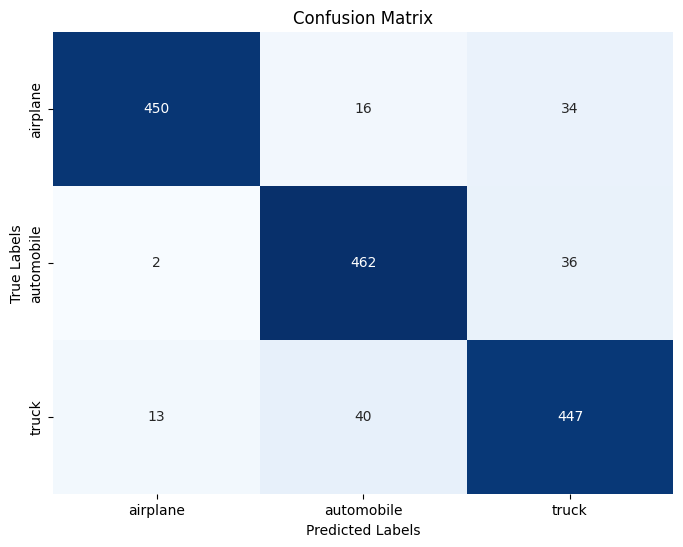

In [ ]:
# Predict on the test dataset
y_pred_prob = ref_model.predict(test_data_gen)  # Predictions as probabilities
y_pred = np.argmax(y_pred_prob, axis=1)         # Convert probabilities to class indices
y_true = test_data_gen.classes                  # True labels from the test generator

# Get class labels
class_indices = test_data_gen.class_indices
class_labels = list(class_indices.keys())

#Creating Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

#Creating Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
accuracy = accuracy_score(y_true, y_pred)

# Print Classification Report
print("Classification Report:")
print(report)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

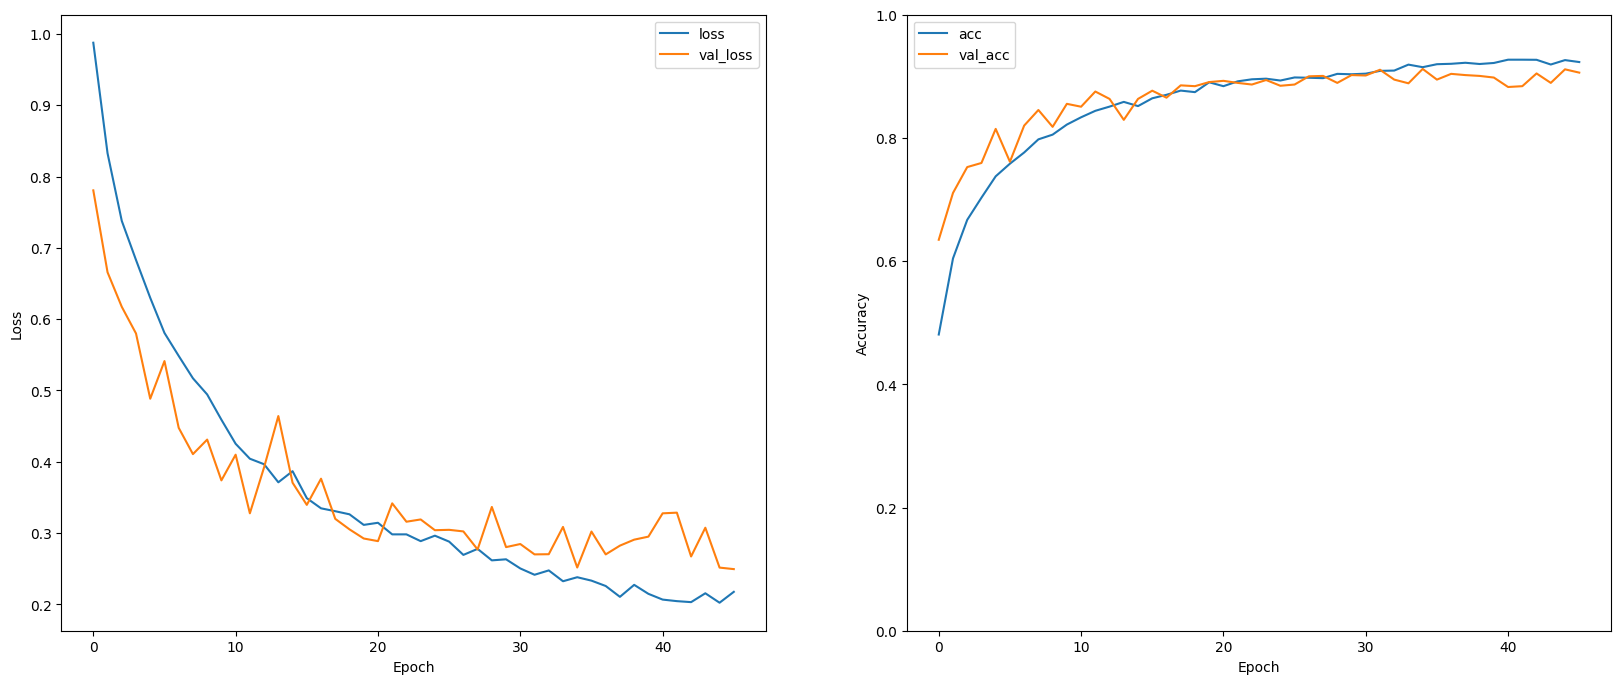

In [ ]:
loss = ref_history.history['loss']
val_loss = ref_history.history['val_loss']
acc = ref_history.history['accuracy']
val_acc = ref_history.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc,label='acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])

plt.show()

# Summary of CNN Model
The model used 5 convolutional layers with an activation function of ReLu, each convolutional layer being followed by a pooling layer of (2,2), flatten and 2 dense layers,with activation of Relu and Softmax respectively, were used.
50 epochs were set to run, with only 46 running due to early stopping.
To address overfitting, data augmentation, including horizontal flip, width & height shift range and zoom range of 0.1, was used. Dropout of 0.8 after the flatten layer, together with L2 regularization(penalty of 0.001) was used as well. Early stop monitoring train accuracy was used, with patience set to 5.
For optimizers, I used Adam, with a learning rate of 0.001.
A train and validation accuracy of 0.9232 and 0.9060 was achieved on the last epoch, and both overall accuracy and F1 score of the model being 0.91.





#TRANSFER LEARNING

Not summary, just a note: I ran MobileNetV2, VGG16, Densenet121 and InceptionV3. Ran on their best input size (224,224), except for inception (299,299)

## MobileNet

In [ ]:
train_dir = r"C:\Users\matti\Downloads\230208B Project\230208B Project\Project Data\dataset_transport\train"
test_dir = r"C:\Users\matti\Downloads\230208B Project\230208B Project\Project Data\dataset_transport\test"

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 32
epochs = 15
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
train_image_generator = ImageDataGenerator(
                    rescale=1./255, rotation_range=10,
                    width_shift_range=.10, height_shift_range=.10,
                    horizontal_flip=True)

validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle = False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 6000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D

#modify input_shape and classifier layers
MobileNet_base_model=MobileNetV2(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

x = MobileNet_base_model.output
# x = Flatten()(x)
x=GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x= Dropout(0.4)(x)
preds=Dense(3, activation='softmax')(x)

Mobile_Model=Model(inputs=MobileNet_base_model.input, outputs=preds)

In [ ]:
MobileNet_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
#freeze base model layers
MobileNet_base_model.trainable = False

# Let's confirm all the layers of convolutional base are frozen.
for layer in MobileNet_base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

In [ ]:
path_checkpoint= r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)
modelckpt_callback=keras.callbacks.ModelCheckpoint(
    monitor="accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
Mobile_Model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = Mobile_Model.fit(train_data_gen,epochs=epochs,validation_data=test_data_gen, callbacks=[es_callback, modelckpt_callback])

Epoch 1/15
187/188 [============================>.] - ETA: 0s - loss: 0.9967 - accuracy: 0.4997
Epoch 1: accuracy improved from -inf to 0.49917, saving model to C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 9s 27ms/step - loss: 0.9970 - accuracy: 0.4992 - val_loss: 0.9111 - val_accuracy: 0.5840
Epoch 2/15
186/188 [============================>.] - ETA: 0s - loss: 0.9329 - accuracy: 0.5416
Epoch 2: accuracy improved from 0.49917 to 0.54150, saving model to C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 5s 24ms/step - loss: 0.9327 - accuracy: 0.5415 - val_loss: 0.8807 - val_accuracy: 0.6040
Epoch 3/15
187/188 [============================>.] - ETA: 0s - loss: 0.9122 - accuracy: 0.5632
Epoch 3: accuracy improved from 0.54150 to 0.56283, saving model to C:\Users\Marcus\Documents\NYP\NYP

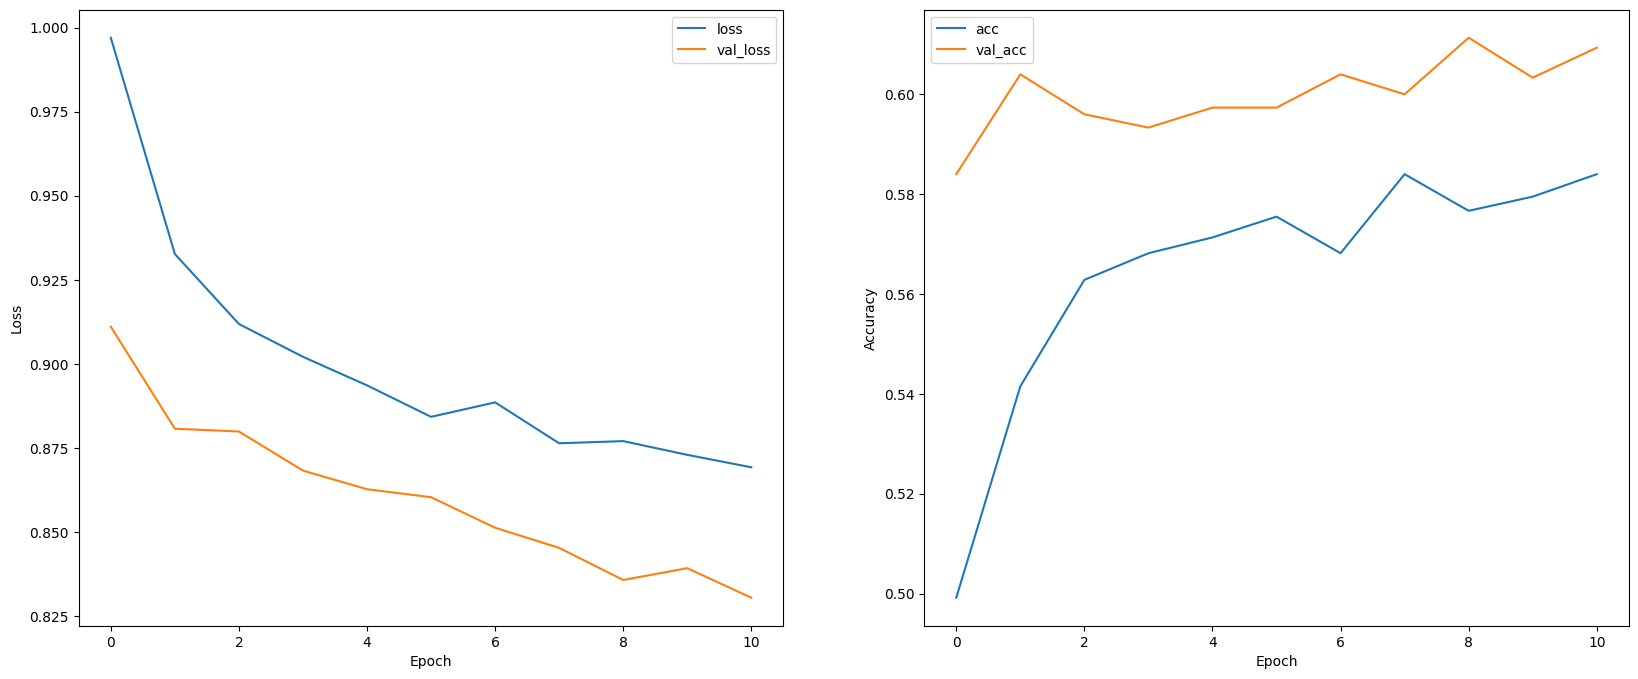

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc,label='acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

47/47 [==============================] - 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.72      0.72       500
  automobile       0.57      0.39      0.47       500
       truck       0.55      0.71      0.62       500

    accuracy                           0.61      1500
   macro avg       0.61      0.61      0.60      1500
weighted avg       0.61      0.61      0.60      1500

Overall Accuracy: 60.93%


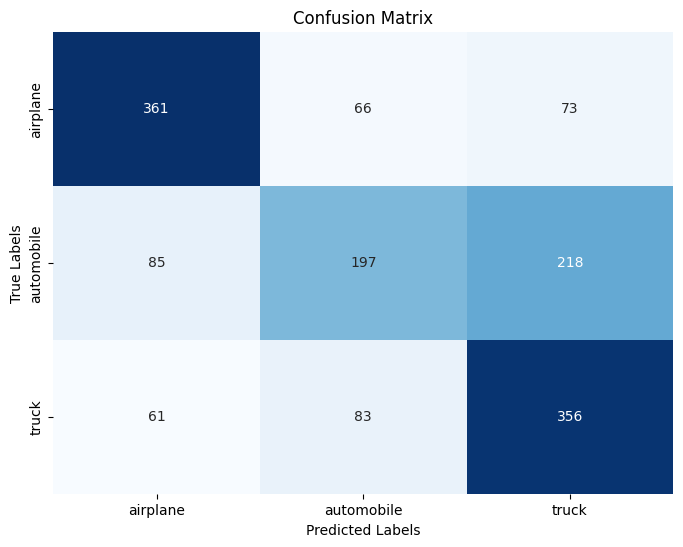

In [ ]:
# Predict on the test dataset
y_pred_prob = Mobile_Model.predict(test_data_gen)  # Predictions as probabilities
y_pred = np.argmax(y_pred_prob, axis=1)         # Convert probabilities to class indices
y_true = test_data_gen.classes                  # True labels from the test generator

# Get class labels
class_indices = test_data_gen.class_indices
class_labels = list(class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
accuracy = accuracy_score(y_true, y_pred)

# Print Classification Report
print("Classification Report:")
print(report)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)  # Create a DataFrame for better readability
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)   # Plot the heatmap
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## VGG

In [ ]:
train_dir = r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\dataset_transport\train"
test_dir = r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\dataset_transport\test"

IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 32
epochs = 20
np.random.seed(42)
tf.random.set_seed(42)

train_image_generator = ImageDataGenerator(
                    rescale=1./255, rotation_range=10,
                    width_shift_range=.10, height_shift_range=.10,
                    horizontal_flip=True)

validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle = False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

In [ ]:
from keras.applications.vgg16 import VGG16

VGG_base_model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
x = VGG_base_model.output
# x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x= Dropout(0.4)(x)
prediction = Dense(3, activation='softmax')(x)

VGG_model_230208B = Model(inputs=VGG_base_model.input, outputs=prediction)
VGG_model_230208B.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#freeze base model layers
VGG_base_model.trainable = False

# Let's confirm all the layers of convolutional base are frozen.
for layer in VGG_base_model.layers:
    print(layer.name, layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
path_checkpoint= r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)
modelckpt_callback=keras.callbacks.ModelCheckpoint(
    monitor="accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
VGG_model_230208B.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = VGG_model_230208B.fit(train_data_gen,epochs=epochs,validation_data=test_data_gen, callbacks=[es_callback, modelckpt_callback])

Epoch 1/15
188/188 [==============================] - ETA: 0s - loss: 1.0017 - accuracy: 0.4992
Epoch 1: accuracy improved from -inf to 0.49917, saving model to C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 7s 30ms/step - loss: 1.0017 - accuracy: 0.4992 - val_loss: 0.7698 - val_accuracy: 0.6907
Epoch 2/15
187/188 [============================>.] - ETA: 0s - loss: 0.8021 - accuracy: 0.6411
Epoch 2: accuracy improved from 0.49917 to 0.64083, saving model to C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 4s 24ms/step - loss: 0.8028 - accuracy: 0.6408 - val_loss: 0.6852 - val_accuracy: 0.7107
Epoch 3/15
188/188 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.6785
Epoch 3: accuracy improved from 0.64083 to 0.67850, saving model to C:\Users\Marcus\Documents\NYP\NYP

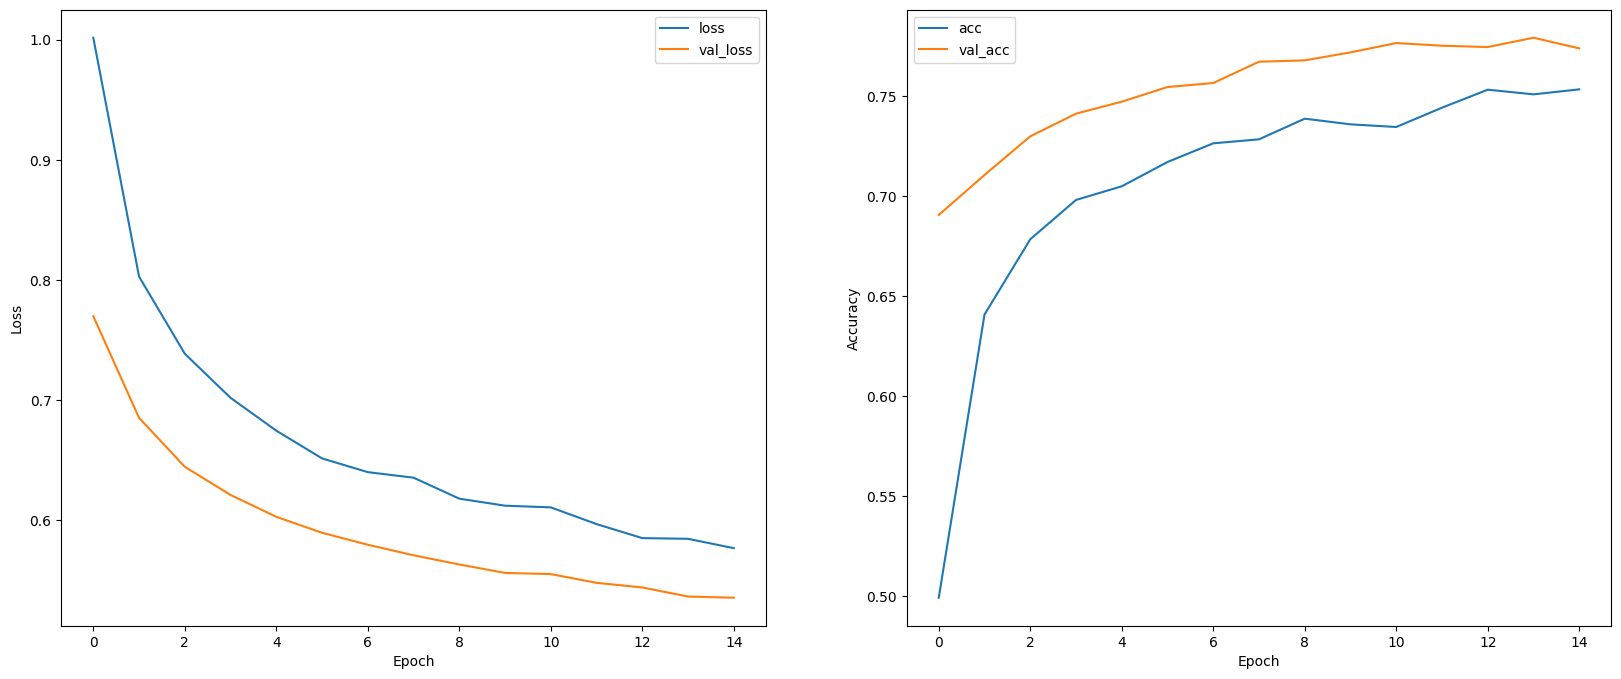

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc,label='acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

47/47 [==============================] - 1s 17ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.85      0.86      0.85       500
  automobile       0.77      0.71      0.74       500
       truck       0.71      0.75      0.73       500

    accuracy                           0.77      1500
   macro avg       0.77      0.77      0.77      1500
weighted avg       0.77      0.77      0.77      1500

Overall Accuracy: 77.40%


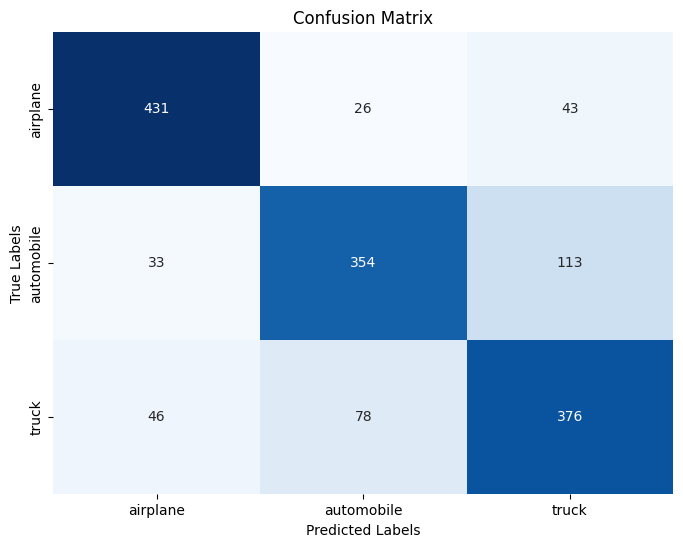

In [ ]:
# Predict on the test dataset
y_pred_prob = VGG_model_230208B.predict(test_data_gen)  # Predictions as probabilities
y_pred = np.argmax(y_pred_prob, axis=1)         # Convert probabilities to class indices
y_true = test_data_gen.classes                  # True labels from the test generator

# Get class labels
class_indices = test_data_gen.class_indices
class_labels = list(class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
accuracy = accuracy_score(y_true, y_pred)

# Print Classification Report
print("Classification Report:")
print(report)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)  # Create a DataFrame for better readability
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)   # Plot the heatmap
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
train_dir = r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\dataset_transport\train"
test_dir = r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\dataset_transport\test"

IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 32
epochs = 20
np.random.seed(42)
tf.random.set_seed(42)

train_image_generator = ImageDataGenerator(
                    rescale=1./255, rotation_range=10,
                    width_shift_range=.10, height_shift_range=.10,
                    horizontal_flip=True)

validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle = False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

# Modify input shape and classifier layers
Dense_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = Dense_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

Dense_Model230208B = Model(inputs=Dense_base_model.input, outputs=preds)

In [ ]:
Dense_Model230208B.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
#freeze base model layers
Dense_base_model.trainable = False

# Let's confirm all the layers of convolutional base are frozen.
for layer in Dense_base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
zero_padding2d False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_1 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_conc

In [ ]:
path_checkpoint= r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)
modelckpt_callback=keras.callbacks.ModelCheckpoint(
    monitor="accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
Dense_Model230208B.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = Dense_Model230208B.fit(train_data_gen,epochs=epochs,validation_data=test_data_gen, callbacks=[es_callback, modelckpt_callback])

Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.7947
Epoch 1: accuracy improved from -inf to 0.79467, saving model to C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 46s 213ms/step - loss: 0.5076 - accuracy: 0.7947 - val_loss: 0.3832 - val_accuracy: 0.8553
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8652
Epoch 2: accuracy improved from 0.79467 to 0.86517, saving model to C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 40s 212ms/step - loss: 0.3499 - accuracy: 0.8652 - val_loss: 0.5634 - val_accuracy: 0.7573
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.8733
Epoch 3: accuracy improved from 0.86517 to 0.87333, saving model to C:\Users\Marcus\Documents\NYP

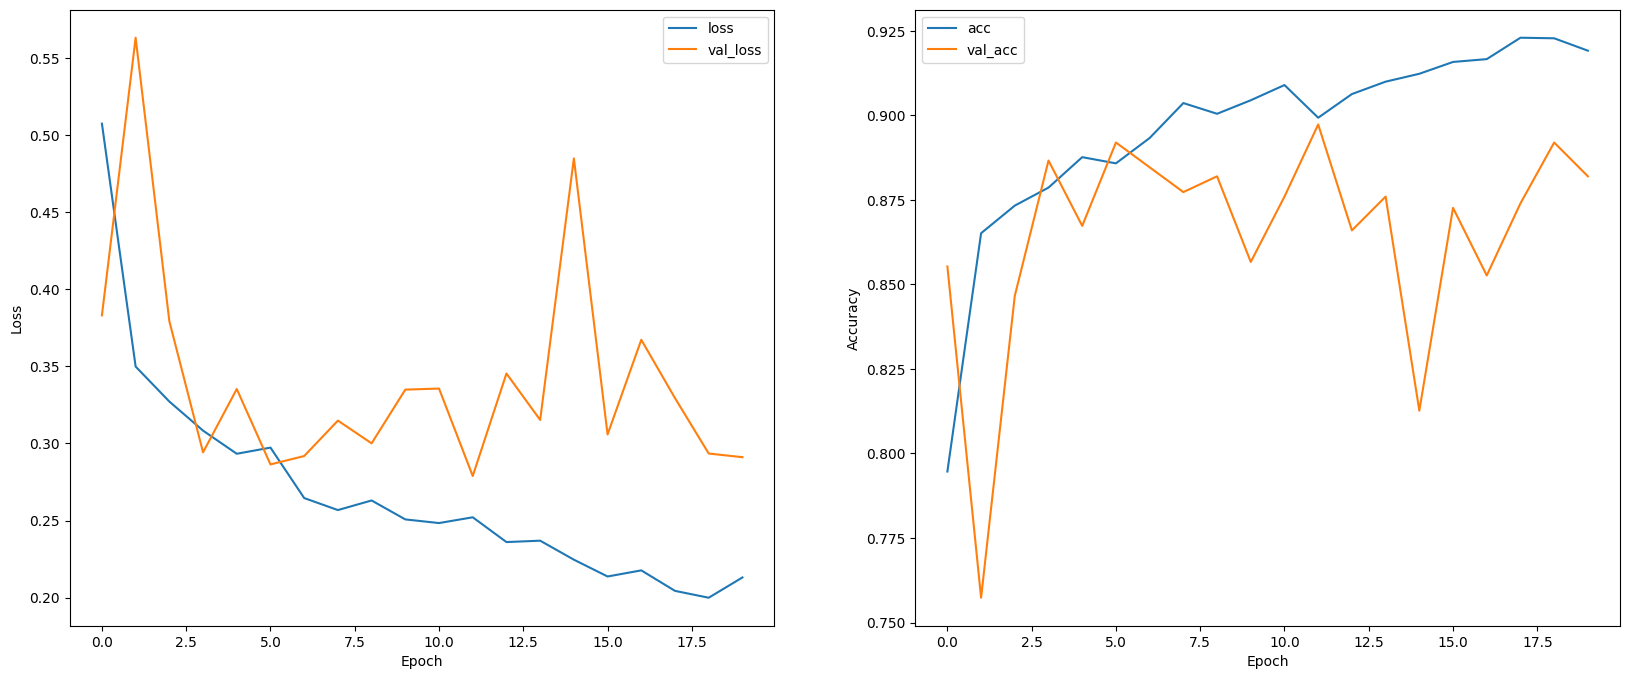

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc,label='acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

47/47 [==============================] - 7s 138ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.97      0.85      0.91       500
  automobile       0.85      0.89      0.87       500
       truck       0.84      0.90      0.87       500

    accuracy                           0.88      1500
   macro avg       0.89      0.88      0.88      1500
weighted avg       0.89      0.88      0.88      1500

Overall Accuracy: 88.20%


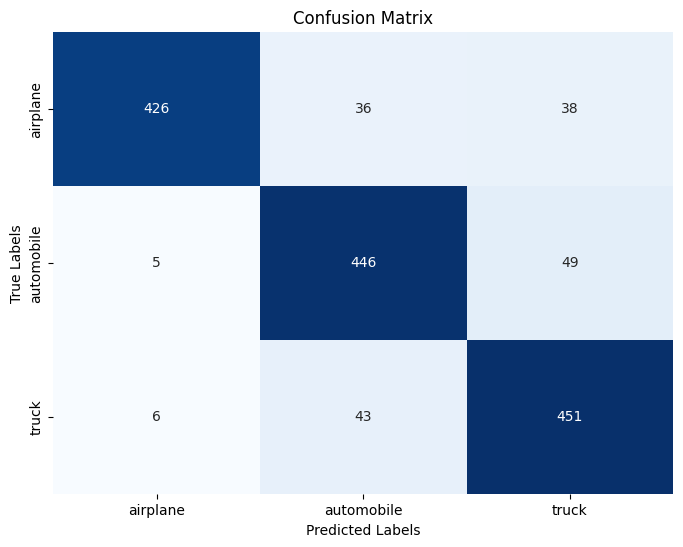

In [ ]:
# Predict on the test dataset
y_pred_prob = Dense_Model230208B.predict(test_data_gen)  # Predictions as probabilities
y_pred = np.argmax(y_pred_prob, axis=1)         # Convert probabilities to class indices
y_true = test_data_gen.classes                  # True labels from the test generator

# Get class labels
class_indices = test_data_gen.class_indices
class_labels = list(class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
accuracy = accuracy_score(y_true, y_pred)

# Print Classification Report
print("Classification Report:")
print(report)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)  # Create a DataFrame for better readability
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)   # Plot the heatmap
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
train_dir = r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\dataset_transport\train"
test_dir = r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\dataset_transport\test"

In [ ]:
IMG_HEIGHT = 299
IMG_WIDTH = 299
batch_size = 32
epochs = 20
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
train_image_generator = ImageDataGenerator(
                    rescale=1./255, rotation_range=10,
                    width_shift_range=.10, height_shift_range=.10,
                    horizontal_flip=True)

validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(299, 299),
                                                           class_mode='categorical')

test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle = False,
                                                              target_size=(299, 299),
                                                              class_mode='categorical')

Found 6000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

# Modify input shape and classifier layers
Incept_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = Incept_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

Incept_Model230208B = Model(inputs=Incept_base_model.input, outputs=preds)

In [ ]:
#freeze base model layers
Incept_base_model.trainable = False

# Let's confirm all the layers of convolutional base are frozen.
for layer in Incept_base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
activati

In [ ]:
path_checkpoint= r"C:\Users\matti\Downloads\230208B Project\230208B Project\Project Data\model_checkpoint.weights.h5"
#path_checkpoint= r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5"
#borrowed another pc as it was too computationally expensive
es_callback = keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)
modelckpt_callback=keras.callbacks.ModelCheckpoint(
    monitor="accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
Incept_Model230208B.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = Incept_Model230208B.fit(train_data_gen,epochs=epochs,validation_data=test_data_gen, callbacks=[es_callback, modelckpt_callback])

Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.8025
Epoch 1: accuracy improved from -inf to 0.80250, saving model to C:\Users\matti\Downloads\230208B Project\230208B Project\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 211s 1s/step - loss: 0.4741 - accuracy: 0.8025 - val_loss: 0.2339 - val_accuracy: 0.9127
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8630
Epoch 2: accuracy improved from 0.80250 to 0.86300, saving model to C:\Users\matti\Downloads\230208B Project\230208B Project\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 50s 265ms/step - loss: 0.3447 - accuracy: 0.8630 - val_loss: 0.2232 - val_accuracy: 0.9187
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8732
Epoch 3: accuracy improved from 0.86300 to 0.87317, saving model to C:\Users\matti\Downloads\230208B Project\230208B 

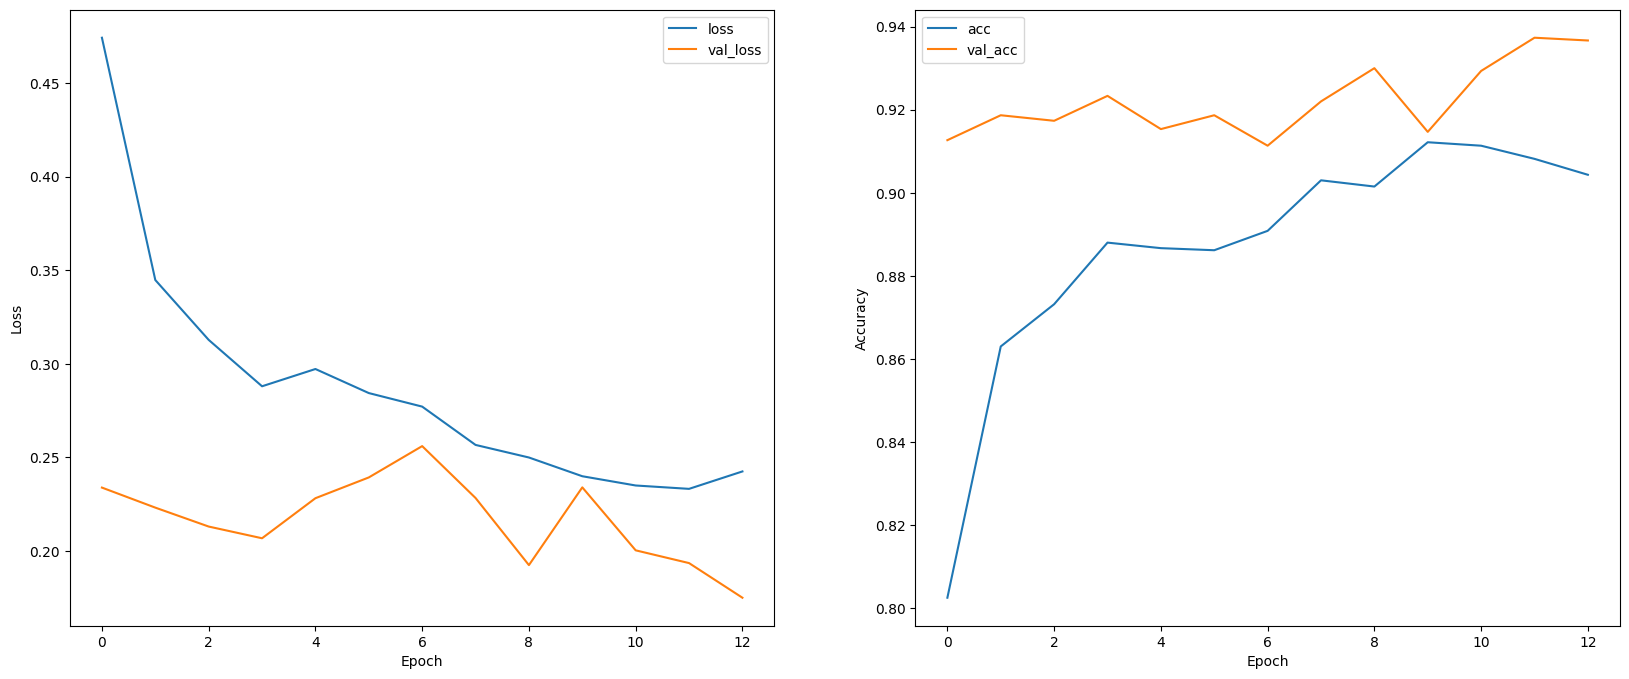

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc,label='acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

47/47 [==============================] - 34s 710ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.96      0.95      0.95       500
  automobile       0.93      0.95      0.94       500
       truck       0.92      0.91      0.92       500

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500

Overall Accuracy: 93.67%


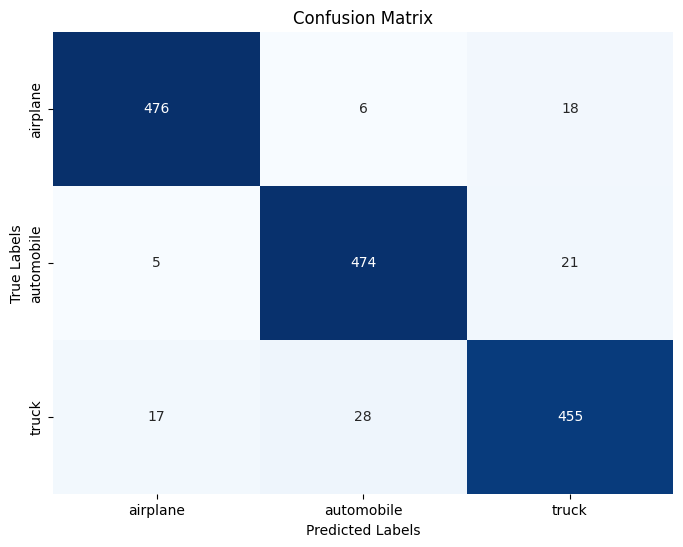

In [ ]:
# Predict on the test dataset
y_pred_prob = Incept_Model230208B.predict(test_data_gen)  # Predictions as probabilities
y_pred = np.argmax(y_pred_prob, axis=1)         # Convert probabilities to class indices
y_true = test_data_gen.classes                  # True labels from the test generator

# Get class labels
class_indices = test_data_gen.class_indices
class_labels = list(class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
accuracy = accuracy_score(y_true, y_pred)

# Print Classification Report
print("Classification Report:")
print(report)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)  # Create a DataFrame for better readability
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)   # Plot the heatmap
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Let's try Inception, seems to perform the best. Let's finetune inception model:

In [ ]:
#Define freeze and unfrozen layers
for layer in Incept_Model230208B.layers[:15]:
  layer.trainable=False

for layer in Incept_Model230208B.layers[15:]:
  layer.trainable=True

In [ ]:
path_checkpoint= r"C:\Users\matti\Downloads\230208B Project\230208B Project\Project Data\model_checkpoint.weights.h5"
#path_checkpoint= r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\model_checkpoint.weights.h5"
#borrowed another pc as it was too computationally expensive
es_callback = keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)
modelckpt_callback=keras.callbacks.ModelCheckpoint(
    monitor="accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
Incept_Model230208B.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = Incept_Model230208B.fit(train_data_gen,epochs=epochs,validation_data=test_data_gen, callbacks=[es_callback, modelckpt_callback])

Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8660
Epoch 1: accuracy improved from -inf to 0.86600, saving model to C:\Users\matti\Downloads\230208B Project\230208B Project\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 63s 318ms/step - loss: 0.3409 - accuracy: 0.8660 - val_loss: 0.1585 - val_accuracy: 0.9373
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9250
Epoch 2: accuracy improved from 0.86600 to 0.92500, saving model to C:\Users\matti\Downloads\230208B Project\230208B Project\Project Data\model_checkpoint.weights.h5
188/188 [==============================] - 54s 286ms/step - loss: 0.2025 - accuracy: 0.9250 - val_loss: 0.1360 - val_accuracy: 0.9527
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9390
Epoch 3: accuracy improved from 0.92500 to 0.93900, saving model to C:\Users\matti\Downloads\230208B Project\230208

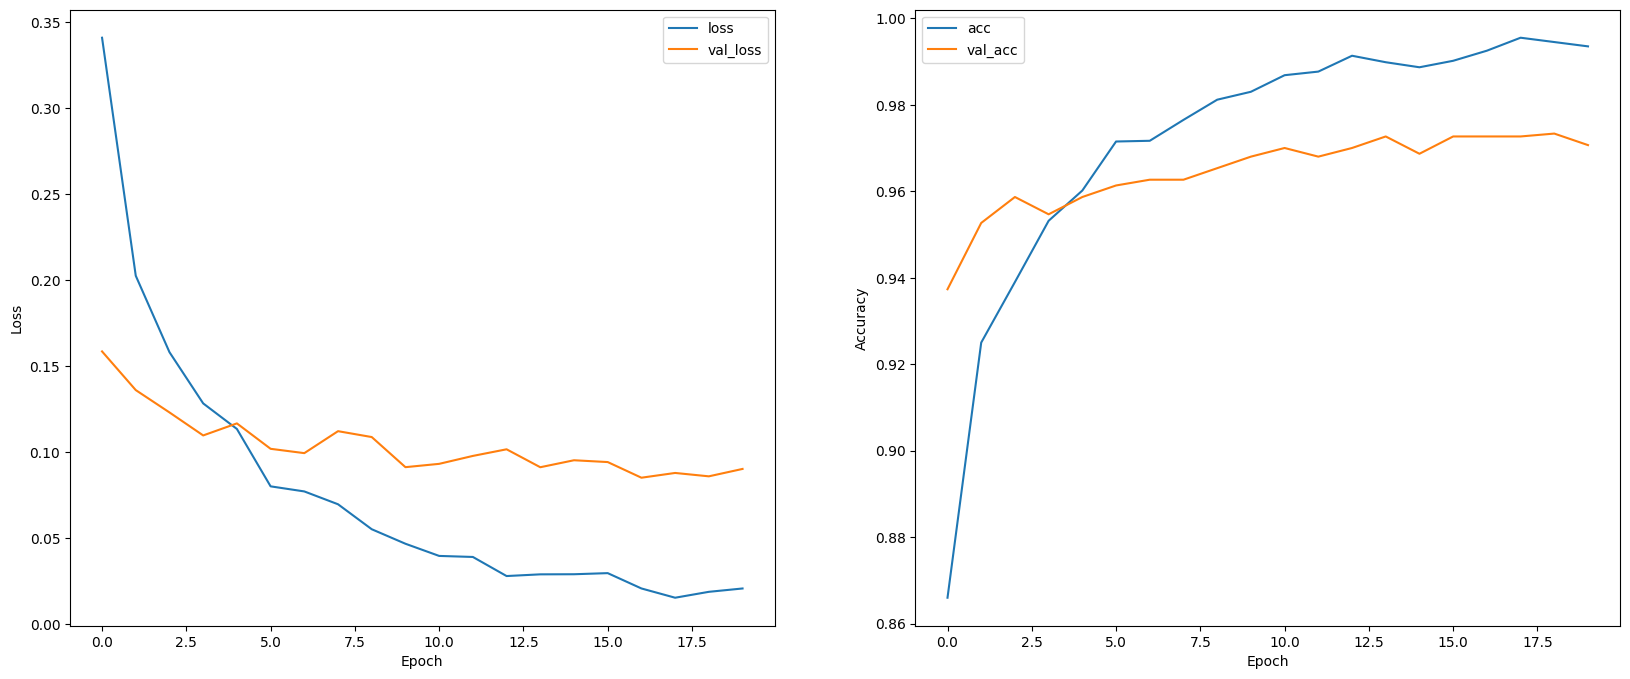

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc,label='acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

47/47 [==============================] - 15s 90ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.99      0.98      0.98       500
  automobile       0.96      0.98      0.97       500
       truck       0.97      0.96      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

Overall Accuracy: 97.07%


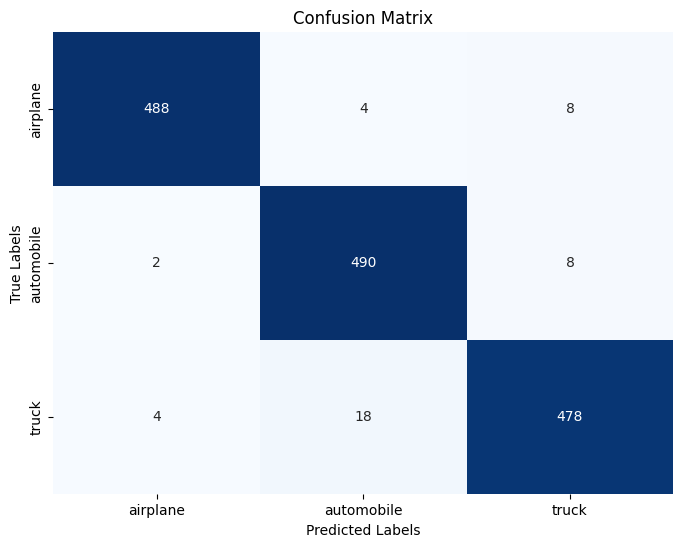

In [ ]:
# Predict on the test dataset
y_pred_prob = Incept_Model230208B.predict(test_data_gen)  # Predictions as probabilities
y_pred = np.argmax(y_pred_prob, axis=1)         # Convert probabilities to class indices
y_true = test_data_gen.classes                  # True labels from the test generator

# Get class labels
class_indices = test_data_gen.class_indices
class_labels = list(class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
accuracy = accuracy_score(y_true, y_pred)

# Print Classification Report
print("Classification Report:")
print(report)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)  # Create a DataFrame for better readability
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)   # Plot the heatmap
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Summary of Transfer Learning
I ran MobileNetV2, VGG16, Densenet121 and InceptionV3 to see the best model. The accuracy was: 0.6090, 0.7740, 0.8820 and 0.9367 respectively. Hence, I decided to choose Inception for fine tuning.
For fine tuning, I unfroze all but the first 15 layers.
To address overfitting, Data augmentation, including horizontal flip, rotation range of 10, width and height shift range of 0.1 was used. Early stopping, monitoring train accuracy was used, with patience set to 3.  A dropout of 0.4 was added to the fine tuning model.
Learning rate of 0.001 and 1e-5 was set for base and fine tuning.
A train accuracy, validation accuracy , train loss and validation loss of 0.9945, 0.9707, 0.0187 and 0.0859 respectively was achieved for the best epoch for my fine tuning model, and both overall accuracy and F1 score being 0.9945 and 0.97 respectively.


# Comparison
CNN was able to achieve a train accuracy, validation accuracy, train loss, validation loss and F1 score of 0.9232 ,0.9060, 0.2175, 0.2494 and 0.91 respectively, while Transfer Learning achieved of 0.9945, 0.9707, 0.0187, 0.0859 and 0.97 respectively.
I chose Transfer learning as it was able to achieve a way higher result as compared to CNN. There was a validation accuracy difference of 0.071, and a validation loss difference of 0.1635 between the 2 models. Both results barely show any sign of overfitting as well, with a train and validation accuracy difference of 0.0238 and 0.0172  for transfer learning and CNN respectively.
While Transfer learning may provide way higher results, it is also more computationally expensive as compared to CNN. My Transfer learning model had at least 24 million parameters while my CNN model only had 4 million parameters.



1/1 [==============================] - 0s 23ms/step


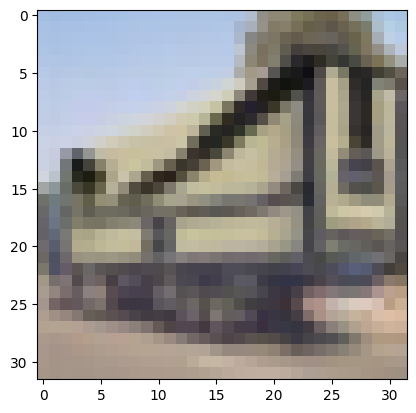

The model prediction is: truck
airplane: 0.01
automobile: 0.00
truck: 0.99


In [ ]:
#bonus: test with image
img_path = r"C:\Users\Marcus\Documents\NYP\NYPY2\NYP Y2S2\EGT214 Deep Learning\Project Data\dataset_transport\test\truck\0010.png"
img = utils.load_img(img_path, target_size=(32, 32))
img_tensor = utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = img_tensor / 255.0


pred = Incept_Model230208B.predict(img_tensor)  # Get probabilities for each class
predicted_class_index = np.argmax(pred[0])  # Get index of the highest probability
class_names = class_labels
plt.imshow(img_tensor[0])
plt.show()
print(f"The model prediction is: {class_names[predicted_class_index]}")
for i, prob in enumerate(pred[0]):
    print(f"{class_names[i]}: {prob:.2f}")